In [1]:
import spacy
from spacy.matcher import Matcher 

In [2]:
!pip install visualise-spacy-tree

  Attempting uninstall: pydot
    Found existing installation: pydot 1.4.2
    Uninstalling pydot-1.4.2:
      Successfully uninstalled pydot-1.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 9.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.8.2 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.5.1 which is incompatible.
apache-beam 2.40.0 requires pyarrow<8.0.0,>=0.15.1, but you have pyarrow 9.0.0 which is incompatible.


In [10]:
from spacy import displacy 
import visualise_spacy_tree
from IPython.display import Image, display
import glob
import pandas as pd

In [11]:
nlp = spacy.load('en_core_web_sm',disable=['ner','textcat'])

## Sample Dataset

In [ ]:
# Folder path
folders = glob.glob('./UNGD/UNGDC 1970-2018/Converted sessions/Session*')

# Dataframe
df = pd.DataFrame(columns={'Country','Speech','Session','Year'})

# Read speeches by India
i = 0 
for file in folders:
    
    speech = glob.glob(file+'/IND*.txt')

    with open(speech[0],encoding='utf8') as f:
        # Speech
        df.loc[i,'Speech'] = f.read()
        # Year 
        df.loc[i,'Year'] = speech[0].split('_')[-1].split('.')[0]
        # Session
        df.loc[i,'Session'] = speech[0].split('_')[-2]
        # Country
        df.loc[i,'Country'] = speech[0].split('_')[0].split("\\")[-1]
        # Increment counter
        i += 1 
        
df.head()

## Pre-process text

In [23]:
# function to preprocess speech
def clean(text):
    
    # removing paragraph numbers
    text = re.sub('[0-9]+.\t','',str(text))
    # removing new line characters
    text = re.sub('\n ','',str(text))
    text = re.sub('\n',' ',str(text))
    # removing apostrophes
    text = re.sub("'s",'',str(text))
    # removing hyphens
    text = re.sub("-",' ',str(text))
    text = re.sub("— ",'',str(text))
    # removing quotation marks
    text = re.sub('\"','',str(text))
    # removing salutations
    text = re.sub("Mr\.",'Mr',str(text))
    text = re.sub("Mrs\.",'Mrs',str(text))
    # removing any reference to outside text
    text = re.sub("[\(\[].*?[\)\]]", "", str(text))
    
    return text

# preprocessing speeches
df['Speech_clean'] = df['Speech'].apply(clean)

## Splitting sentences

In [32]:
# split sentences
def sentences(text):
    # split sentences and questions
    text = re.split('[.?]', text)
    clean_sent = []
    for sent in text:
        clean_sent.append(sent)
    return clean_sent

# sentences
df['Sent'] = df['Speech_clean'].apply(sentences)

In [39]:
# create a dataframe containing sentences
df2 = pd.DataFrame(columns=['Sent','Year','Len'])

row_list = []

for i in range(len(df)):
    for sent in df.loc[i,'sent']:
    
        wordcount = len(sent.split())
        year = df.loc[i,'Year']

        dict1 = {'Year':year,'Sent':sent,'Len':wordcount}
        row_list.append(dict1)
    
df2 = pd.DataFrame(row_list)

In [40]:
df2.head()

""


## IE 1

In [41]:
# function to find sentences containing PMs of India
def find_names(text):
    
    names = []
    
    # spacy doc
    doc = nlp(text)
    
    # pattern
    pattern = [{'LOWER':'prime'},
              {'LOWER':'minister'},
              {'POS':'ADP','OP':'?'},
              {'POS':'PROPN'}]
                
    # Matcher class object 
    matcher = Matcher(nlp.vocab) 
    matcher.add("names", None, pattern) 

    matches = matcher(doc)

    # finding patterns in the text
    for i in range(0,len(matches)):
        
        # match: id, start, end
        token = doc[matches[i][1]:matches[i][2]]
        # append token to list
        names.append(str(token))
    
    # Only keep sentences containing Indian PMs
    for name in names:
        if (name.split()[2] == 'of') and (name.split()[3] != "India"):
                names.remove(name)
            
    return names

# apply function
df2['PM_Names'] = df2['Sent'].apply(find_names)

KeyError: 'Sent'

In [37]:
# look at sentences for a specific year
for i in range(len(df2)):
    if df2.loc[i,'Year'] in ['1984']:
        if len(df2.loc[i,'PM_Names'])!=0:
            print('->',df2.loc[i,'Sent'],'\n')

In [38]:
count=0
for i in range(len(df2)):
    if len(df2.loc[i,'PM_Names'])!=0:
        count+=1
print(count)

0


## Using intelligent regex alongwith Spacy

In [42]:
# to check if keyswords like 'programs','schemes', etc. present in sentences

def prog_sent(text):
    
    patterns = [r'\b(?i)'+'plan'+r'\b',
               r'\b(?i)'+'programme'+r'\b',
               r'\b(?i)'+'scheme'+r'\b',
               r'\b(?i)'+'campaign'+r'\b',
               r'\b(?i)'+'initiative'+r'\b',
               r'\b(?i)'+'conference'+r'\b',
               r'\b(?i)'+'agreement'+r'\b',
               r'\b(?i)'+'alliance'+r'\b']

    output = []
    flag = 0
    for pat in patterns:
        if re.search(pat, text) != None:
            flag = 1
            break
    return flag 

# apply function
df2['Check_Schemes'] = df2['Sent'].apply(prog_sent)


KeyError: 'Sent'

In [43]:
# to extract initiatives using pattern matching
def all_schemes(text,check):
    
    schemes = []
    
    doc = nlp(text)
    
    # initiatives
    prog_list = ['programme','scheme',
                 'initiative','campaign',
                 'agreement','conference',
                 'alliance','plan']
    
    # pattern to match initiatives names 
    pattern = [{'POS':'DET'},
               {'POS':'PROPN','DEP':'compound'},
               {'POS':'PROPN','DEP':'compound'},
               {'POS':'PROPN','OP':'?'},
               {'POS':'PROPN','OP':'?'},
               {'POS':'PROPN','OP':'?'},
               {'LOWER':{'IN':prog_list},'OP':'+'}
              ]
    
    if check == 0:
        # return blank list
        return schemes

    # Matcher class object 
    matcher = Matcher(nlp.vocab) 
    matcher.add("matching", None, pattern) 
    matches = matcher(doc)

    for i in range(0,len(matches)):
        
        # match: id, start, end
        start, end = matches[i][1], matches[i][2]
        
        if doc[start].pos_=='DET':
            start = start+1
        
        # matched string
        span = str(doc[start:end])
        
        if (len(schemes)!=0) and (schemes[-1] in span):
            schemes[-1] = span
        else:
            schemes.append(span)
        
    return schemes

# apply function
df2['Schemes1'] = df2.apply(lambda x:all_schemes(x.Sent,x.Check_Schemes),axis=1)

ValueError: Wrong number of items passed 0, placement implies 1

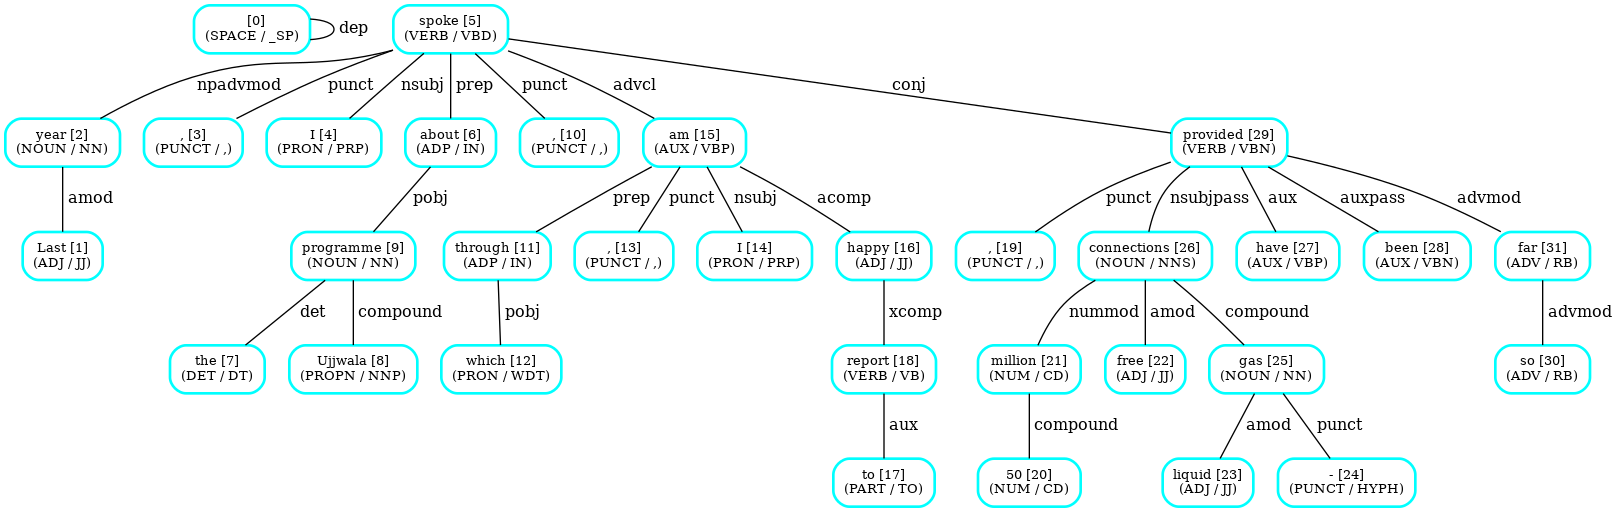

In [44]:
doc = nlp(' Last year, I spoke about the Ujjwala programme , through which, I am happy to report, 50 million free liquid-gas connections have been provided so far')
png = visualise_spacy_tree.create_png(doc)
display(Image(png))

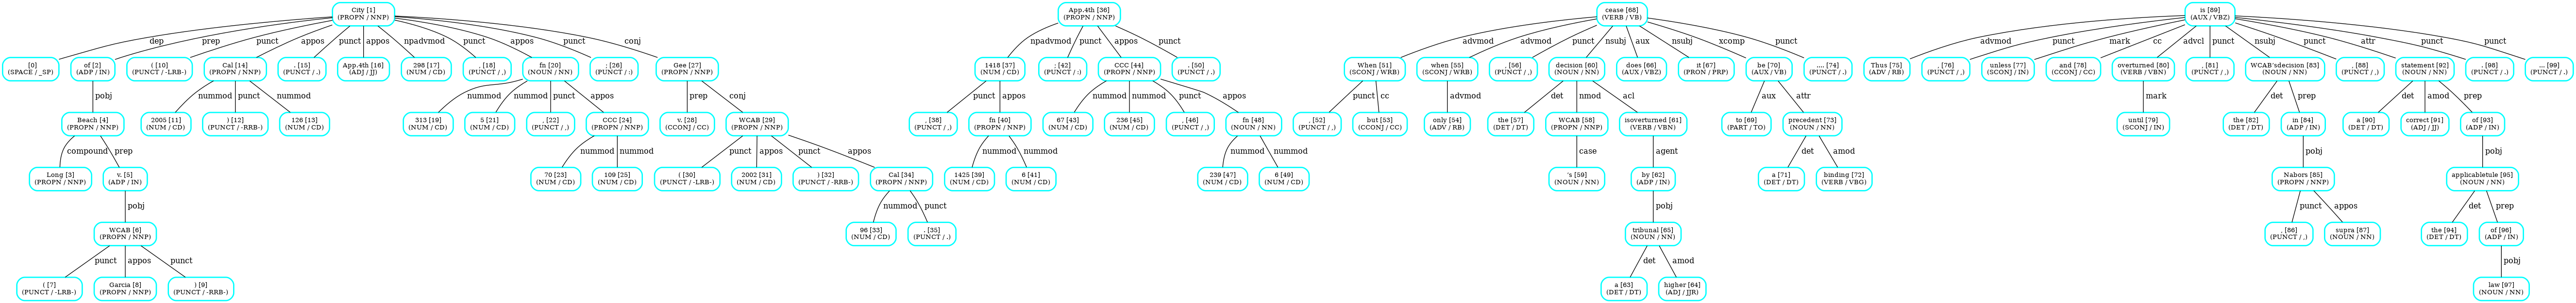

In [46]:
doc = nlp(''' City of Long Beach v. WCAB (Garcia) (2005) 126 Cal.App.4th 298, 313 fn 5, 70 CCC 109; Gee v. WCAB (2002) 96 Cal.App.4th 1418, 1425 fn 6; 67 CCC 236, 239 fn 6. When, but only when, the WCAB’s decision isoverturned by a higher tribunal does it cease to be a binding precedent .... Thus, unless and until overturned, the WCAB’sdecision in Nabors, supra, is a correct statement of the applicabletule of law. ...''')
png = visualise_spacy_tree.create_png(doc)
display(Image(png))

In [47]:
# rule to extract initiative name
def sent_subtree(text):
    
    # pattern match for schemes or initiatives
    patterns = [r'\b(?i)'+'plan'+r'\b',
           r'\b(?i)'+'programme'+r'\b',
           r'\b(?i)'+'scheme'+r'\b',
           r'\b(?i)'+'campaign'+r'\b',
           r'\b(?i)'+'initiative'+r'\b',
           r'\b(?i)'+'conference'+r'\b',
           r'\b(?i)'+'agreement'+r'\b',
           r'\b(?i)'+'alliance'+r'\b']
    
    schemes = []
    doc = nlp(text)
    flag = 0
    # if no initiative present in sentence
    for pat in patterns:
        
        if re.search(pat, text) != None:
            flag = 1
            break
    
    if flag == 0:
        return schemes

    # iterating over sentence tokens
    for token in doc:

        for pat in patterns:
                
            # if we get a pattern match
            if re.search(pat, token.text) != None:

                word = ''
                # iterating over token subtree
                for node in token.subtree:
                    # only extract the proper nouns
                    if (node.pos_ == 'PROPN'):
                        word += node.text+' '

                if len(word)!=0:
                    schemes.append(word)

    return schemes      

# derive initiatives
df2['Schemes2'] = df2['Sent'].apply(sent_subtree)

KeyError: 'Sent'